In [26]:
from vector_operations import Vector

def num_differences(v1: Vector, v2: Vector) -> int:
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1,v2) if x1 != x2])

print(f'num_differences([1,2,3],[2,1,3]) = {num_differences([1,2,3],[2,1,3])}')
print(f'num_differences([1,2],[1,2]) = {num_differences([1,2],[1,2])}')

num_differences([1,2,3],[2,1,3]) = 2
num_differences([1,2],[1,2]) = 0


In [27]:
from typing import List
from vector_operations import vector_mean
import random

def cluster_means(k: int,
                 imputs: List[Vector],
                 assignments: List[int]) -> List[Vector]:
    # cluster i contains the inputs whose assignment is i
    clusters = [[] for i in range(k)]
    
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)
        
    # if cluster is empty then just use a random point
    return [vector_mean(cluster) if cluster else random.choice(inputs)
            for cluster in clusters]

In [28]:
import itertools
import tqdm
from vector_operations import squared_distance

class kMeans:
    def __init__(self, k: int) -> None:
        self.k = k # number of clusters
        self.means = None
        
    def classify(self, input: Vector)->int:
        """Return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key = lambda i: squared_distance(input,self.means[i]))
    
    def train(self, inputs: List[Vector]) -> None:
        # Start with random assignments
        assignments = [random.randrange(self.k) for _ in inputs]
        #print(inputs[:10])
        #print(assignments[:10])
        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, assignments)
                #print(self.means)
                new_assignments = [self.classify(input) for input in inputs]
                
                # Check how many assignments changed and if we are done
                
                num_changed = num_differences(assignments, new_assignments)
                
                if num_changed == 0:
                    return
                # Otherwise keep the new assignments and compute new means
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed}/{len(inputs)}")  

In [29]:
# Example: meetups

inputs: List[List[float]] = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

random.seed(12)
clusterer = kMeans(k = 3)
clusterer.train(inputs)

means = sorted(clusterer.means) # sort for the unit test

# Check that the means are close to what we expect
assert squared_distance(means[0], [-44, 5]) < 1
assert squared_distance(means[1], [-16, -10]) < 1
assert squared_distance(means[2], [18, 20]) < 1    

changed: 5/20: : 0it [00:00, ?it/s]


In [30]:
random.seed(12)
clusterer = kMeans(k = 2)
clusterer.train(inputs)


means = sorted(clusterer.means)
assert len(means) == 2
assert squared_distance(means[0], [-26, -5]) < 1
assert squared_distance(means[1], [18, 20]) < 1    

changed: 1/20: : 0it [00:00, ?it/s]


In [31]:
from matplotlib import pyplot as plt

def squared_clustering_errors(inputs: List[Vector], k: int) -> float:
    """finds the total squared error from the k-means clustering of inputs"""
    clusterer = kMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = [clusterer.classify(input) for input in inputs]
    
    return sum(squared_distance(input, means[cluster]) 
               for input, cluster in zip(inputs, assignments))

In [32]:
# now plot from 1 up to len(inputs) clusters

ks = range(1, len(inputs) + 1)
errors = [squared_clustering_errors(inputs, k) for k in ks]

0it [00:00, ?it/s]
changed: 3/20: : 0it [00:00, ?it/s] 
changed: 2/20: : 0it [00:00, ?it/s] 
changed: 3/20: : 0it [00:00, ?it/s] 
changed: 1/20: : 0it [00:00, ?it/s] 
changed: 7/20: : 0it [00:00, ?it/s] 
changed: 1/20: : 0it [00:00, ?it/s] 
changed: 1/20: : 0it [00:00, ?it/s] 
changed: 1/20: : 0it [00:00, ?it/s] 
changed: 7/20: : 0it [00:00, ?it/s] 
changed: 2/20: : 0it [00:00, ?it/s] 
changed: 2/20: : 0it [00:00, ?it/s] 
changed: 4/20: : 0it [00:00, ?it/s] 
changed: 8/20: : 0it [00:00, ?it/s] 
changed: 2/20: : 0it [00:00, ?it/s] 
changed: 1/20: : 0it [00:00, ?it/s] 
changed: 11/20: : 0it [00:00, ?it/s]
changed: 1/20: : 0it [00:00, ?it/s] 
changed: 1/20: : 0it [00:00, ?it/s] 
changed: 1/20: : 0it [00:00, ?it/s] 


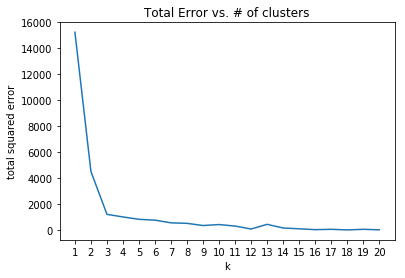

In [33]:
plt.plot(ks,errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.title("Total Error vs. # of clusters")
plt.show()

In [34]:
from typing import NamedTuple, Union, List
from vector_operations import Vector
class Leaf(NamedTuple):
    value: Vector

leaf1 = Leaf([10, 20])
leaf2 = Leaf([30, -15])

class Merged(NamedTuple):
    children: tuple
    order: int
        
merged = Merged((leaf1, leaf2), order = 1)

Cluster = Union[Leaf, Merged]

In [35]:
def get_values(cluster: Cluster) -> List[Vector]:
    if isinstance(cluster, Leaf):
        return [cluster.value]
    else:
        return [value
               for child in cluster.children
               for value in get_values(child)]
    
print(f"get_values(merged) = {get_values(merged)}")

get_values(merged) = [[10, 20], [30, -15]]


In [36]:
from typing import Callable
from vector_operations import distance

def cluster_distance(cluster1: Cluster,
                    cluster2: Cluster,
                    distance_agg: Callable = min) -> float:
    """Compute all the pairwise distances between cluster1 and cluster2 and apply the aggregation function
    _distance_agg_ to the resulting list"""
    
    return distance_agg([distance(v1,v2)]
                       for v1 in get_values(cluster1)
                       for v2 in get_values(cluster2))

In [37]:
def get_merge_order(cluster: Cluster) -> float:
    if isinstance(cluster, Leaf):
        return float('inf') # was never merged
    else:
        return cluster.order

In [38]:
from typing import Tuple

def get_children(cluster: Cluster):
    if isinstance(cluster, Leaf):
        return TypeError("Leaf has no children")
    else:
        return cluster.children

In [48]:
def bottom_up_cluster(inputs: List[Vector],
                     distance_agg: Callable = min) -> Cluster:
    # Start with all leaves
    clusters: List[Cluster] = [Leaf(input) for input in inputs]
        
    def pair_distance(pair: Tuple[Cluster, Cluster]) -> float:
        return cluster_distance(pair[0], pair[1], distance_agg)
    
    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find two closest clusters
        c1, c2 = min(((cluster1, cluster2)
                     for i, cluster1 in enumerate(clusters)
                     for cluster2 in clusters[:i]),
                     key = pair_distance)
        
        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]
        
        # merge them using merge_order = # of clusters left
        
        merged_cluster = Merged((c1,c2), order = len(clusters))
        
        # and add their merge
        clusters.append(merged_cluster)
        
    # when there is only one cluster left, return it
    return clusters[0]

In [49]:
inputs: List[List[float]] = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

base_cluster = bottom_up_cluster(inputs)

In [50]:
def generate_clusters(base_cluster: Cluster,
                     num_clusters: int) -> List[Cluster]:
    # start with a list with just the base cluster
    clusters = [base_cluster]
    
    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last merged of our clusters
        next_cluster = min(clusters, key = get_merge_order)
        clusters = [c for c in clusters if c != next_cluster]
        
        # and add its children to the list (i.e. unmerge it)
        clusters.extend(get_children(next_cluster))
        
    # once we have enough clusters, return those
    return clusters

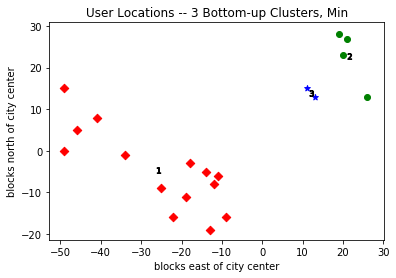

In [51]:
three_clusters = [get_values(cluster) for cluster in generate_clusters(base_cluster, 3)]
from matplotlib import pyplot as plt


for i, cluster, marker, color in zip([1,2,3],
                                    three_clusters,
                                    ['D','o', '*'],
                                    ['r','g','b']):
    xs, ys = zip(*cluster) # magic unzipping trick
    plt.scatter(xs, ys, color = color, marker = marker)
    
    # put a number at the mean of a cluster
    x,y = vector_mean(cluster)
    plt.plot(x,y, marker = '$' + str(i) + '$', color = 'black')
    
plt.title("User Locations -- 3 Bottom-up Clusters, Min")
plt.xlabel("blocks east of city center")
plt.ylabel("blocks north of city center")
plt.show()